First let's define some code to fetch the data:

In [14]:
from datetime import date, datetime
from urllib.request import urlopen
from json import loads

def datestring_to_date(datestring):
    from datetime import datetime
    return datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ")

def get_crime_reports(start=date(2015,1,1), end=date(2016,3,1), incident_types=range(0,200)):
    """
    Gets a set of crime reports for the VicPD in roughly the Victoria area from start to end dates. This will take a bit due to rate limiting and the volume of data produced.

    Returns a list of CrimeReports.
    """
    # This covers most of Victoria
    rows = range(2831, 2834)
    cols = range(1286, 1291)
    
    start_param = start.strftime("%Y/%m/%d")
    end_param = end.strftime("%Y/%m/%d")

    crimes = []
    incident_types = ",".join([str(x) for x in incident_types])
    
    for row in rows:
        for col in cols:
            #print("Getting row "+str(row)+" col "+str(col))
            url = "https://www.crimereports.com/v3/crime_reports/map/search_by_tile.json?start_date="+start_param+"&end_date="+end_param+"&incident_type_ids="+incident_types+"&org_ids=1550&row="+str(row)+"&column="+str(col)+"&zoom=13&include_sex_offenders=false"
            raw_data = urlopen(url).read().decode("utf-8")
            this_data = loads(raw_data)
            if this_data["crimes"]:
                #print(str(len(this_data["crimes"]))+" crimes found on this tile")
                for item in this_data["crimes"]:
                    crimes.append(item)
                    
    # It was discovered that the data is frequently duplicated. Let's dedup.
    seen_ids = set()
    unique_crimes = []
    for crime in crimes:
        if crime["id"] not in seen_ids:
            seen_ids.add(crime["id"])
            unique_crimes.append(crime)

    return unique_crimes

Now lets get the crimes arranged by category, first we need to build out the categories. Initial data retrieved by running the following JS in page console. Figured out by inspecting the minified source.

```js
categories = {};
categoryTypes.map(function (x) {
    created_cat = {};
    created_cat.id = x.id;
    if (x.children) {
        created_cat.children = {};
        x.children.map(function (y) {
            created_subcat = {};
            created_subcat.id = y.id;
            created_cat.children[y.name] = created_subcat;
        });
    }
    categories[x.name] = created_cat;
});
JSON.stringify(categories, null, 2)

```

In [3]:
categories = {
  "Homicide": {
    "id": 104,
    "children": {}
  },
  "Breaking & Entering": {
    "id": 100,
    "children": {}
  },
  "Robbery": {
    "id": 98,
    "children": {}
  },
  "Theft": {
    "id": 103,
    "children": {}
  },
  "Theft of Vehicle": {
    "id": 99,
    "children": {}
  },
  "Theft from Vehicle": {
    "id": 101,
    "children": {}
  },
  "Vehicle Recovery": {
    "id": 170,
    "children": {}
  },
  "Sexual Offense": {
    "id": 8,
    "children": {
      "Other Sexual Offense": {
        "id": 97
      },
      "Sexual Assault": {
        "id": 148
      }
    }
  },
  "Assault ": {
    "id": 9,
    "children": {
      "Assault": {
        "id": 149
      },
      "Assault with Deadly Weapon": {
        "id": 150
      }
    }
  },
  "Property Crime ": {
    "id": 10,
    "children": {
      "Property Crime": {
        "id": 180
      },
      "Property Crime Commercial": {
        "id": 179
      },
      "Property Crime Residential": {
        "id": 178
      }
    }
  },
  "Other ": {
    "id": 11,
    "children": {
      "Alarm": {
        "id": 160
      },
      "Arson": {
        "id": 121
      },
      "Death": {
        "id": 162
      },
      "Family Offense": {
        "id": 164
      },
      "Kidnapping": {
        "id": 165
      },
      "Missing Person": {
        "id": 167
      },
      "Other": {
        "id": 151
      },
      "Weapons Offense": {
        "id": 171
      }
    }
  },
  "Quality of Life": {
    "id": 12,
    "children": {
      "Disorder": {
        "id": 163
      },
      "Drugs": {
        "id": 168
      },
      "Liquor": {
        "id": 166
      }
    }
  },
  "Traffic": {
    "id": 169,
    "children": {}
  },
  "Fire": {
    "id": 15,
    "children": {}
  },
  "Emergency": {
    "id": 16,
    "children": {}
  },
  "Proactive Policing": {
    "id": 14,
    "children": {
      "Community Policing": {
        "id": 161
      },
      "Pedestrian Stop": {
        "id": 173
      },
      "Vehicle Stop": {
        "id": 172
      }
    }
  }
}

# Build a lookup dict 
category_id_lookup = {}
for category_name,category in categories.items():
    category_id_lookup[category["id"]] = category
    if category["children"]:
        for child_name,child in category["children"].items():
            category_id_lookup[child["id"]] = child
for category in category_id_lookup.keys():
    category_id_lookup[category]["crimes"] = []

In [4]:
# Get all the reports. This takes a few seconds and is thus it's on cell. Avoid re-running this.
crimes = get_crime_reports(incident_types=category_id_lookup.keys())

Arrange the crimes into their appropriate places.

In [5]:
for crime in crimes:
    category = category_id_lookup[crime['incident_type_id']]
    category["crimes"].append(crime)

# Frequency Breakdowns

In [6]:
for category,data in categories.items():
    print("{:5d} {:30s}".format(len(data["crimes"]), category))
    for child_name,child_data in data["children"].items():
        print("\t {:5d} {:30s}".format(len(child_data["crimes"]), child_name))

    0 Other                         
	     0 Death                         
	     0 Missing Person                
	    17 Arson                         
	    55 Weapons Offense               
	     0 Kidnapping                    
	  1626 Other                         
	    95 Alarm                         
	     0 Family Offense                
    0 Homicide                      
  301 Breaking & Entering           
    0 Sexual Offense                
	     0 Other Sexual Offense          
	     0 Sexual Assault                
    0 Fire                          
 1526 Traffic                       
    0 Proactive Policing            
	   244 Vehicle Stop                  
	   416 Pedestrian Stop               
	     1 Community Policing            
   53 Robbery                       
    0 Emergency                     
  111 Theft of Vehicle              
    0 Vehicle Recovery              
    0 Quality of Life               
	   173 Disorder                      
	   689 Li

It was noted that the "parents" are not necessarily composed of their children. This is probably due to legacy data.

# Drugs on Fridays

(We copied this so we can confirm it's working.)

In [7]:
## Heatmap, drugs on Fridays
import folium
from folium import plugins
data = []
for crime in categories["Quality of Life"]["children"]["Drugs"]["crimes"]:
    # If the date is Friday
    if datestring_to_date(crime["incident_date_time"]).weekday() == 4:
        data.append([crime["lat"], crime["lng"], 0.1])
        
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(data))
mapa

# Theft Morning/Afternoon/Night

First, day between 2AM and 12PM:

In [8]:
## Heatmap, theft on days or nights.
import folium
from folium import plugins
morning = []; afternoon = []; night = [];
for crime in categories["Theft"]["crimes"]:
    # If the date is Friday
    hour_of_crime = datestring_to_date(crime["incident_date_time"]).time().hour
    if (hour_of_crime > 2 and hour_of_crime < 12):
        morning.append([crime["lat"], crime["lng"], 0.1])
    elif (hour_of_crime > 12 and hour_of_crime < 20):
        afternoon.append([crime["lat"], crime["lng"], 0.1])
    else:
        night.append([crime["lat"], crime["lng"], 0.1])
        
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(morning))
mapa

In [9]:
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(afternoon))
mapa

In [10]:
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(night))
mapa

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


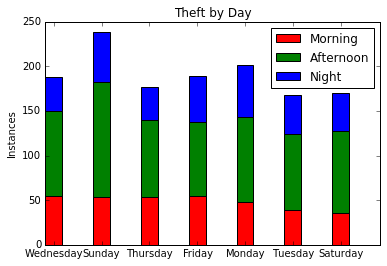

In [22]:
%pylab inline

import numpy
import matplotlib.pyplot as plot

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ind = numpy.arange(len(days))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

morning = [0]*7; afternoon = [0]*7; night = [0]*7;
for crime in categories["Theft"]["crimes"]:
    # If the date is Friday
    hour_of_crime = datestring_to_date(crime["incident_date_time"]).time().hour
    day_of_week = datestring_to_date(crime["incident_date_time"]).weekday()
    if (hour_of_crime > 2 and hour_of_crime < 12):
        morning[day_of_week] += 1
    elif (hour_of_crime > 12 and hour_of_crime < 20):
        afternoon[day_of_week] += 1
    else:
        night[day_of_week] += 1
        
morning_bar = plot.bar(ind, morning, width, color="r", label="Morning")
afternoon_bar = plot.bar(ind, afternoon, width, color="g", label="Afternoon", bottom=morning)
night_bar = plot.bar(ind, night, width, color="b", label="Night", bottom=[x+y for x,y in zip(morning,afternoon)])

plot.ylabel('Instances')
plot.title('Theft by Day')
plot.xticks(ind + width/2., set(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]))
plot.legend()

plot.show()